Enter the Fish classification Kaggle Competition

https://www.kaggle.com/c/the-nature-conservancy-fisheries-monitoring/data

* use vgg
* model solution off of lesson 1.
* finetune and try to figure out how to do a softmax.
* check your code into a git repo on either github or gitlab.

In [2]:
# start jupyter notebook in the Lesson2 directory. 
%pwd


u'/home/ubuntu/my-repo/homework/lesson2'

In [1]:
import os, sys

current_dir = os.getcwd()
HOME_DIR = current_dir
DATA_DIR = HOME_DIR + '/data'

In [2]:
sys.path.insert(1, os.path.join(sys.path[0], '..'))

from utils.utils import *
from utils.vgg16 import Vgg16 

%matplotlib inline

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)
Using Theano backend.


In [4]:
%mkdir $DATA_DIR

mkdir: cannot create directory '/home/ubuntu/my-repo/homework/lesson2/data': File exists


In [ ]:
#I had to accept the NDA and enter the competition to download the data.

#download the data and move it into place. use -p for password but don't save it in the notebook if you'd like
%cd $DATA_DIR
%kg config -u telarson -c 'the-nature-conservancy-fisheries-monitoring'
%kg download



In [1]:
#setup the correct directory paths

# full dataset
%cd $DATA_DIR
%mkdir -p test train valid results test/unkown

# sample dataset
%mkdir sample
%cd sample
%mkdir test train valid results

/home/ubuntu/homework/lesson2/data
/home/ubuntu/homework/lesson2/data/sample


#### Setup Training and Test Data

In [7]:
#unpack the data - left off here
#this section got deleted.  rewrote this when really tired.  needs some testing. 
%cd $DATA_DIR
%unzip train.zip
%rm -rf __MACOSX/

#test data (only stage 1 data available now)
%unzip test_stg1.zip
%mv test_stg1 train/unknown



/home/ubuntu/homework/lesson2/data


#### Create Validation and Sample label directories from extracted data

In [6]:
%cd $DATA_DIR/train

#validation
#copy the directories
g = glob('*')
for d in g: 
    if not os.path.exists(DATA_DIR + '/valid/' + d): os.mkdir(DATA_DIR + '/valid/' + d)
    if not os.path.exists(DATA_DIR + '/sample/train/' + d): os.mkdir(DATA_DIR + '/sample/train/' + d)
    if not os.path.exists(DATA_DIR + '/sample/valid/' + d): os.mkdir(DATA_DIR + '/sample/valid/' + d)
    

/home/ubuntu/my-repo/homework/lesson2/data/train


#### Setup Validation Data from Training Data

In [7]:
%cd $DATA_DIR/train

#move random data from train to valid 
g    = glob('*/*.jpg')
VSS  = floor(0.1 * len(g)) #works b/c utils moves floor to global space. 
shuf = np.random.permutation(g)
print shuf[0]
for i in range(VSS): os.rename(shuf[i], DATA_DIR + '/valid/' + shuf[i])

/home/ubuntu/my-repo/homework/lesson2/data/train
YFT/img_01721.jpg


#### Setup Sample Data from Training Data and Validation Data

In [9]:
%cd $DATA_DIR/train

from shutil import copyfile

#left off here - directories now created but this section has never run correctly.  

#sample - training data

g    = glob('*.jpg')  #need to repeat.  some items moved.
SSS  = min(200, len(g))
shuf = np.random.permutation(g)
for i in range(SSS): copyfile(shuf[i], DATA_DIR + '/sample/train'+shuf[i])


#sample - valid data 
%cd $DATA_DIR/valid

g    = glob('*/*.jpg')
shuf = np.random.permutation(g)
SVS  = min(50, len(g))
for i in range(SVS): copyfile(shuf[i], DATA_DIR + '/sample/valid/'+shuf[i])

#NOTE: in cats vs dogs redux teacher doesn't use sample/test directory. uses all test data.  See below. 

/home/ubuntu/my-repo/homework/lesson2/data/train
/home/ubuntu/my-repo/homework/lesson2/data/valid


#### Finetuning and Training

In [3]:
%cd $DATA_DIR

path         = DATA_DIR # + '/sample'
test_path    = DATA_DIR + '/test'  #NOTE: not using sample test directory.  Use ALL test files. 
results_path = path + '/results' #model weights live here. 
train_path   = path + '/train'
valid_path   = path + '/valid'

/home/ubuntu/my-repo/homework/lesson2/data


In [4]:
vgg = Vgg16()

In [5]:
batch_size = 128 # mini-batch size
epochs = 8

In [6]:

#pick the first line if you are using data augmentation.
#batches     = vgg.get_batches(train_path, gen, batch_size = batch_size)
batches     = vgg.get_batches(train_path, batch_size = batch_size)


Found 3060 images belonging to 8 classes.


In [7]:
#finetune the model
val_batches = vgg.get_batches(valid_path, batch_size = batch_size*2)

vgg.finetune(batches)
vgg.model.optimizer.lr = 0.01

Found 717 images belonging to 8 classes.


In [8]:
#Use this if you already trained the weights
latest_weights_filename = 'ft%d.h5' % epochs
if not os.path.exists(results_path + '/' + latest_weights_filename):
    latest_weights_filename = None

In [ ]:
# use this to force model to train the weights
latest_weights_filename = None 
for e in range(epochs):
    print "Running epoch: %d" % e
    vgg.fit(batches, val_batches, nb_epoch=e) #how is validation batch used here?
    latest_weights_filename = 'ft%d.h5' % e
    vgg.model.save_weights(results_path + '/' + latest_weights_filename)


Running epoch: 0
Running epoch: 1
Epoch 1/1
1524/3060 [=============>................] - ETA: 42s - loss: 8.3975 - acc: 0.4790

#### Load Weights from Previous Session

In [13]:
latest_weights_filename = 'ft7.h5' #cheating
print(results_path+ '/' + latest_weights_filename)
vgg.model.load_weights(results_path+ '/' + latest_weights_filename)

/home/ubuntu/my-repo/homework/lesson2/data/results/ft7.h5


#### Generate Synthetic Data

In [67]:
#gen used above when creating the training batch generator
gen = image.ImageDataGenerator(rotation_range=10, width_shift_range=0.1, 
       height_shift_range=0.1, shear_range=0.15, zoom_range=0.2, 
       channel_shift_range=10., horizontal_flip=True, vertical_flip=True)

In [39]:
??ndimage.imread

In [41]:
img_pth= train_path + '/SHARK/img_07860.jpg' 
img_pth= train_path + '/SHARK/img_07498.jpg' 
img_pth= train_path + '/SHARK/img_07003.jpg'
img_pth= train_path + '/LAG/img_07919.jpg'
#other examples of sharks - img_07498.jpg, img_07003.jpg
img = np.expand_dims(ndimage.imread(img_pth),0)
# Request the generator to create batches from this image
aug_iter = gen.flow(img)

In [42]:
aug_imgs = [next(aug_iter)[0].astype(np.uint8) for i in range(8)]

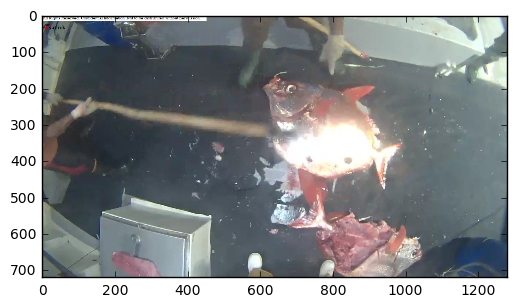

In [43]:
plt.imshow(img[0])

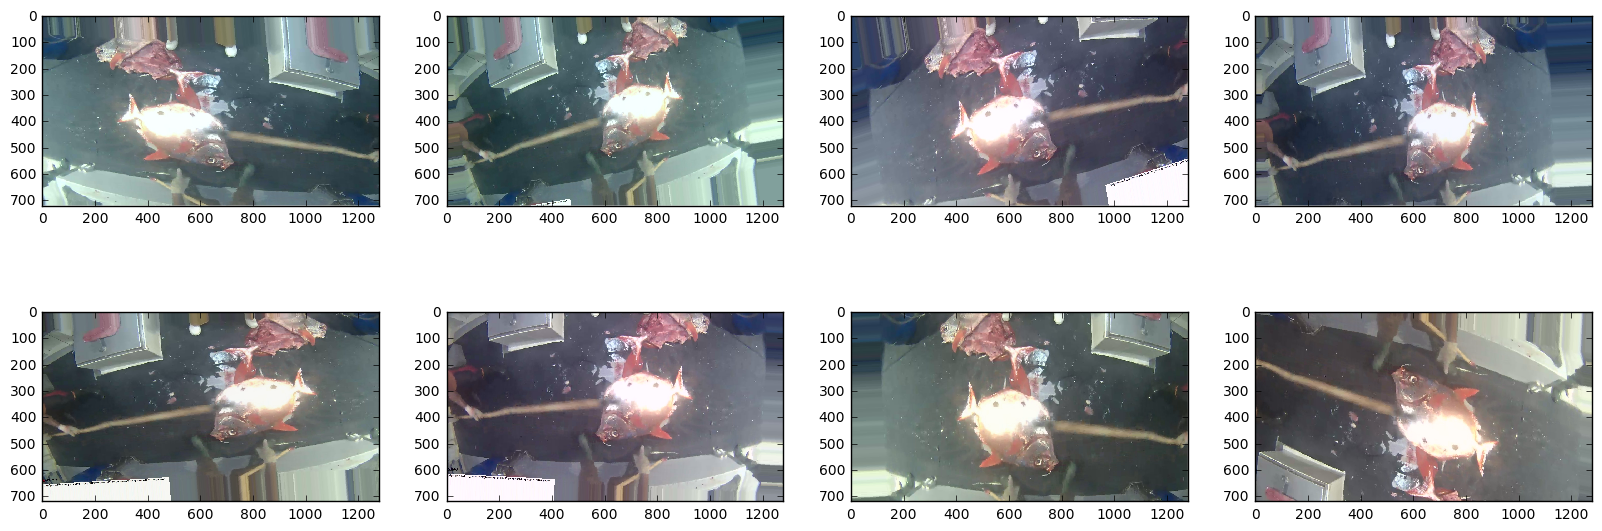

In [44]:
#plot the augmented data
plots(aug_imgs, (20,7), 2)

#### Test batch with Sythentic Data Added

Object `vgg.get_batches` not found.


### Validate predictions

In [17]:
#pbatches, preds = vgg.test(test_path, batch_size=batch_size*2)  #with large batch_size this ran out of memory. 
val_batches, probs = vgg.test(valid_path, batch_size = batch_size)

Found 717 images belonging to 8 classes.


In [25]:
#look at predicted classes (arrays of zeroes and ones)
print probs[:25]

filenames = val_batches.filenames
print filenames[:25]

#dir(pbatches)  #let's see what attributes this object has.  Ideally we want to see the class. 


### left off here.  Is there an easy way to see which class is at which index in the array below?  
# how do we format results to view them? 
# how do we format results to submit them? 

[[  1.0000e+00   0.0000e+00   0.0000e+00   0.0000e+00   0.0000e+00   0.0000e+00   0.0000e+00
    0.0000e+00]
 [  1.0000e+00   0.0000e+00   0.0000e+00   0.0000e+00   0.0000e+00   0.0000e+00   0.0000e+00
    0.0000e+00]
 [  1.0000e+00   0.0000e+00   0.0000e+00   0.0000e+00   0.0000e+00   0.0000e+00   0.0000e+00
    0.0000e+00]
 [  1.0000e+00   0.0000e+00   0.0000e+00   0.0000e+00   0.0000e+00   0.0000e+00   0.0000e+00
    0.0000e+00]
 [  1.0000e+00   0.0000e+00   0.0000e+00   0.0000e+00   0.0000e+00   0.0000e+00   0.0000e+00
    0.0000e+00]
 [  1.0000e+00   0.0000e+00   0.0000e+00   0.0000e+00   0.0000e+00   0.0000e+00   0.0000e+00
    0.0000e+00]
 [  1.0000e+00   0.0000e+00   0.0000e+00   0.0000e+00   0.0000e+00   0.0000e+00   0.0000e+00
    0.0000e+00]
 [  1.0000e+00   0.0000e+00   0.0000e+00   0.0000e+00   0.0000e+00   0.0000e+00   0.0000e+00
    0.0000e+00]
 [  1.0000e+00   0.0000e+00   0.0000e+00   0.0000e+00   0.0000e+00   0.0000e+00   0.0000e+00
    0.0000e+00]
 [  1.0000e+00   0.

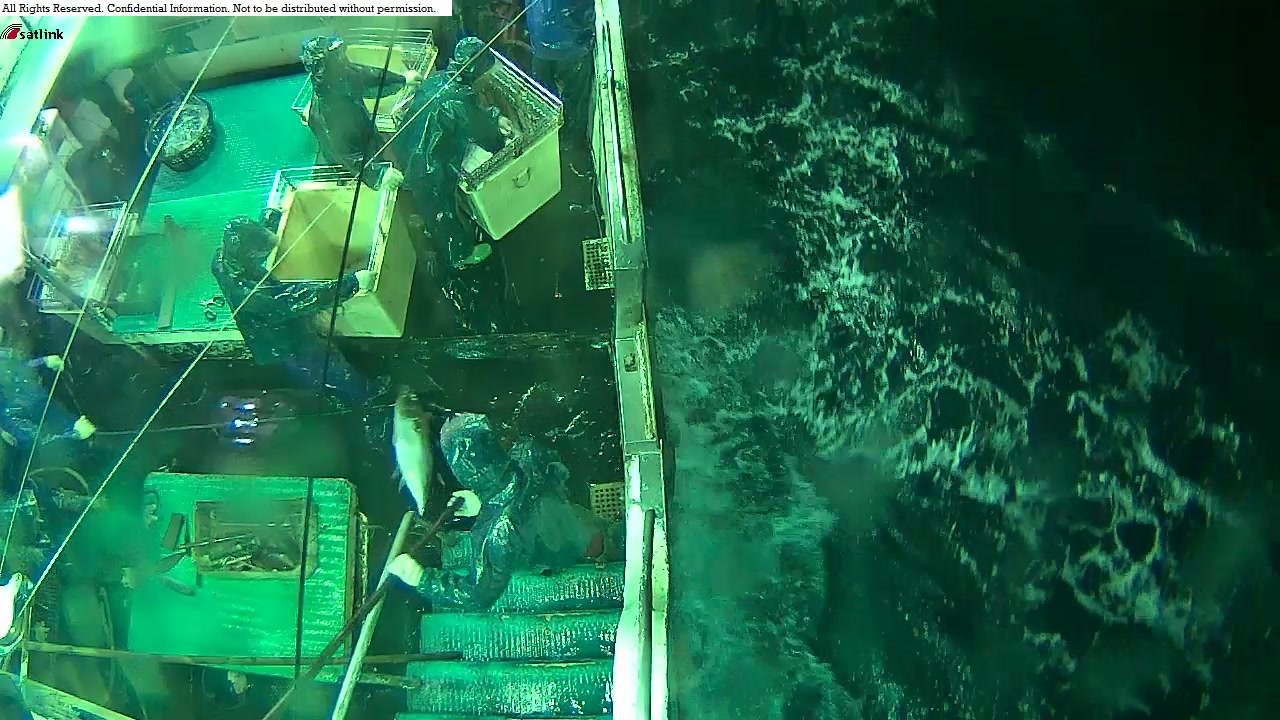

In [24]:
from PIL import Image
Image.open(valid_path + '/' + filenames[0])

In [26]:
type(val_batches)

keras.preprocessing.image.DirectoryIterator

In [56]:
??vgg.get_batches

In [57]:
??get_batches

In [ ]:
#print some stuff.  Don't worry if you got the labels right just yet.

#Helper function to plot images by index in the validation set 
#Plots is a helper function in utils.py
def plots_idx(idx, titles=None):
    plots([image.load_img(valid_path + filenames[i]) for i in idx], titles=titles)
    
#Number of images to view for each visualization task
n_view = 4

